# MADE - Masked Autoencoder for Distribution Estimation

**Paper:** [https://arxiv.org/pdf/1502.03509.pdf](https://arxiv.org/pdf/1502.03509.pdf), **Code:** [#](https://github.com/#), **Website:** [#](#)

> **Abstract:** There has been a lot of recent interest in designing neural network models to estimate a distribution from a set of examples. We introduce a simple modification for autoencoder neural networks that yields powerful generative models. Our method masks the autoencoder’s parameters to respect autoregressive constraints: each input is reconstructed only from previous inputs in a given ordering. Constrained this way, the autoencoder outputs can be interpreted as a set of conditional probabilities, and their product, the full joint probability. We can also train a single network that can decompose the joint probability in multiple different orderings. Our simple framework can be applied to multiple architectures, including deep ones. Vectorized implementations, such as on GPUs, are simple and fast. Experiments demonstrate that this approach is competitive with stateof-the-art tractable distribution estimators. At test time, the method is significantly faster and scales better than other autoregressive estimators.

In [1]:
#@markdown Setup.

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision.transforms as transforms

import seaborn as sns
import pandas as pd
import PIL
import tqdm

## 1. Background

![](https://stackabuse.s3.amazonaws.com/media/image-reconstruction-and-denoising-with-autoencoders-in-python-and-keras-3.png)

In a traditional autoencoder all units are densely connected to all other units of the previous layer. This facilitates full *visibility* between the reconstruction $\mathbf{\hat x}$ and the input $\mathbf{x}$, i.e., information about $x_i$ can flow to all output positions. One drawback of this scheme is that the latent space can become *trivial*. When given enough capacity, the network can learn a simple *copy* function that simply *restates* the input condition rather than utilize *statistical* redundancies/features of the data to perform compression. In these cases, the output likelihoods are 100% for any input, meaning they fail to act as properly normalized probabilities. One way to overcome this is by enforcing autoregression. In this case, each output $\hat x_i$ is a *conditional probability* $\hat x_i = p_\theta(x_i|x_1,\dots,x_{i-1})$. Then the full reconstruction can be expressed as

$$p_\theta(\mathbf{x}) = \prod_{i = 1}^D p_\theta(x_i|x_1,\dots,x_{i-1}) = \prod_{i=1}^D \hat x_i.$$

Since each $\hat x_i \in [0, 1]$, this probability will always remain valid.

To enforce autoregressivity, we must prevent $\hat x_i$ from accessing information about $x_{j \ge i}$. We can do this by zeroing connections in the encoder and decoder matricies so as to prohibit non-causal paths. For example, consider an autoencoder with three input units, four hidden units, and three output units. Suppose we wish to enforce $p(x_1)p(x_2|x_1)p(x_3|x_1,x_2)$. For $\hat x_1$ we must "cut all ties" since it gives an *unconditional* likelihood. For $\hat x_2$, we only allow information from $x_1$. For $\hat x_3$, we only allow information from $x_1$ and $x_2$. The diagram below shows the autoencoder with certain connections cut to preserve causality:

![](https://i.ibb.co/t2kwPLS/MADE.png)

Here, the numbers on each hidden unit denote the inputs on which it depends. In this specific scenario, the first unit of the first hidden layer depends only on $x_1$, whereas the remaining units of that layer depend on both $x_1$ and $x_2$. No unit is permitted to depend on all inputs since that would defeat the autogressive property. In the second hidden layer, we see two hidden units depending only on $x_1$, while two others depend on both $x_1$ and $x_2$. The choice of which hidden units depend on which inputs is rather subjective. The only constraint is that no hidden depends on all inputs. At the output layer, we see that $y_1 = \hat x_1$ depends on nothing. Meanwhile, $y_2$ depends only on $x_1$ whereas $y_3$ depends only on $x_1$ and $x_2$. In the next section we describe a general masking formula.

### 1.2. Generating Masks

To generate masks for each layer, we firstly assign each unit $z_k^l$ a number between $1$ and $D - 1$ (where $D$ is the dimensionality of the input). Denote this by $\text{ID}^l(k)$. We then ensure that for each connection, $z_j^{l-1} \to z_k^l$, we have that $\text{ID}^l(k) \ge \text{ID}^{l-1}(j)$. At the input layer we assign the inputs IDs by $\text{ID}^0(k) = k$. We do the same for the output layer.

This inductively ensures that all units in layer $l$ will only be connected to units in layer $l-1$ having a connection to past inputs. To actually generate the masks, we simply apply the above rule for each position. Namely, the mask for the weights between layer $l-1$ and $l$ is given by

$$\mathbf{M}^{l}_{k', k} = \begin{cases}1 & \text{if } \text{ID}^l(k') \ge \text{ID}^{l-1}(k) \\ 0 & \text{otherwise}\end{cases}.$$

For the output layer we replace $\ge$ with $\gt$.

## 2. Data

In [2]:
#@markdown Download the MNIST dataset.

from torchvision.datasets import MNIST

transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x / 255.),
])

train_dataset = MNIST(root='.', train=True, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 109174753.41it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 76911551.63it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27981208.26it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14388616.89it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



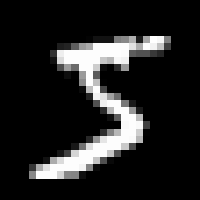

In [3]:
#@markdown

transforms.ToPILImage()(train_dataset[0][0]).resize((200, 200), 0)

## 3. Model

In [4]:
#@markdown Mask generation.

from typing import Tuple

def get_layer_mask(this_layer_ids: Tuple, next_layer_ids: Tuple, is_output: bool = False) -> torch.Tensor:

    this_layer_size = len(this_layer_ids)
    next_layer_size = len(next_layer_ids)

    mask = torch.ones((next_layer_size, this_layer_size))

    # Zero out non-causal connections.

    for i, this_id in enumerate(this_layer_ids):
        for j, next_id in enumerate(next_layer_ids):

            if is_output:
                mask[j, i] = int(next_id > this_id)
            else:
                mask[j, i] = int(next_id >= this_id)
    return mask.to(float)

Some quick tests show that our masking code matches the diagrams in the paper.

In [5]:
get_layer_mask((3, 1, 2), (2, 1, 2, 2))

tensor([[0., 1., 1.],
        [0., 1., 0.],
        [0., 1., 1.],
        [0., 1., 1.]], dtype=torch.float64)

In [6]:
get_layer_mask((2, 1, 2, 2), (1, 2, 2, 1))

tensor([[0., 1., 0., 0.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [0., 1., 0., 0.]], dtype=torch.float64)

In [7]:
get_layer_mask((1, 2, 2, 1), (3, 1, 2), is_output=True)

tensor([[1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [1., 0., 0., 1.]], dtype=torch.float64)

In [8]:
#@markdown Unit ID assignment.

def get_hidden_layer_ids(layer_size: int, input_size: int) -> Tuple:

    return tuple(torch.randint(low=1, high=input_size, size=(layer_size,)).tolist())

In [9]:
#@markdown Model.

import math


class MaskedLinear(nn.Module):
    """A masked linear layer."""

    def __init__(
        self,
        in_features: int,
        out_features: int,
        input_layer_size: int,
        previous_layer_ids: Tuple,
        this_layer_ids: Tuple = None,
        is_output_layer: bool = False,
    ) -> None:
        """Initializes the module."""

        super().__init__()

        self.in_features = in_features
        self.out_features = out_features

        std = math.sqrt(2 / (in_features + out_features))
        self.weight = nn.Parameter(std * torch.randn((out_features, in_features)))
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.layer_ids = this_layer_ids or get_hidden_layer_ids(out_features, input_layer_size)

        self.mask = get_layer_mask(previous_layer_ids, self.layer_ids, is_output=is_output_layer)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass."""

        return x @ (self.weight * self.mask).T + self.bias


class MADE(nn.Module):
    """MADE."""

    def __init__(self) -> None:
        """Initializes the module."""

        super(MADE, self).__init__()

        input_size = 28 * 28
        hidden_size = 500
        input_layer_ids = tuple(range(1, input_size + 1))

        # Encoder.

        self.linear_0 = MaskedLinear(input_size, hidden_size, input_size, input_layer_ids)
        self.linear_1 = MaskedLinear(hidden_size, hidden_size, input_size, self.linear_0.layer_ids)
        #self.linear_2 = MaskedLinear(hidden_size, hidden_size, input_size, self.linear_1.layer_ids)

        # Decoder.

        #self.linear_3 = MaskedLinear(hidden_size, hidden_size, input_size, self.linear_2.layer_ids)
        self.linear_4 = MaskedLinear(hidden_size, hidden_size, input_size, self.linear_1.layer_ids)
        self.linear_5 = MaskedLinear(hidden_size, input_size, input_size, self.linear_4.layer_ids, is_output_layer=True, this_layer_ids=input_layer_ids)

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """Encodes an observation."""

        x = F.relu(self.linear_0(x))
        x = F.relu(self.linear_1(x))
        #x = F.relu(self.linear_2(x))

        return x

    def decode(self, x: torch.Tensor) -> torch.Tensor:
        """Decodes a latent."""

        #x = F.relu(self.linear_3(x))
        x = F.relu(self.linear_4(x))
        x = F.sigmoid(self.linear_5(x))

        return x

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass."""

        z = self.encode(x)
        y = self.decode(z)

        return y, z



## 4. Training

In [10]:
model = MADE()

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [12]:
epochs = 20
batch_size = 256

train_dataloader = D.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    losses = []

    for i, (x, _) in enumerate(train_dataloader):

        x = x.view(-1, 28 * 28).to(float).round()

        optimizer.zero_grad()
        reconstruction, _ = model(x)
        loss = F.binary_cross_entropy(reconstruction, x)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (i % 10) == 0:
            mean_loss = sum(losses) / len(losses)
            losses.clear()

            print(f'epoch {epoch}, batch {i} - loss: {mean_loss}')

epoch 0, batch 0 - loss: 0.6933095152392282
epoch 0, batch 10 - loss: 0.47814847788756626
epoch 0, batch 20 - loss: 0.35502525575291377
epoch 0, batch 30 - loss: 0.32285637736373207
epoch 0, batch 40 - loss: 0.3027750222829761
epoch 0, batch 50 - loss: 0.2882828122121873
epoch 0, batch 60 - loss: 0.2802398014168271
epoch 0, batch 70 - loss: 0.2702965959162916
epoch 0, batch 80 - loss: 0.2611743154026297
epoch 0, batch 90 - loss: 0.2537971390410896
epoch 0, batch 100 - loss: 0.24683211055267612
epoch 0, batch 110 - loss: 0.24388247088469517
epoch 0, batch 120 - loss: 0.23744076590905117
epoch 0, batch 130 - loss: 0.23347261721000753
epoch 0, batch 140 - loss: 0.2305496718853422
epoch 0, batch 150 - loss: 0.2239680907236549
epoch 0, batch 160 - loss: 0.22254106356128908
epoch 0, batch 170 - loss: 0.21713457531589545
epoch 0, batch 180 - loss: 0.2140599721820206
epoch 0, batch 190 - loss: 0.21130372489397428
epoch 0, batch 200 - loss: 0.2075144378046748
epoch 0, batch 210 - loss: 0.204514

KeyboardInterrupt: ignored

## 5. Evaluation

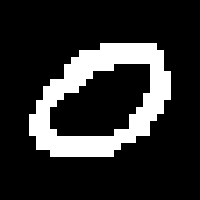

In [13]:
transforms.ToPILImage()(x[202].view(28, 28)).resize((200, 200),0)

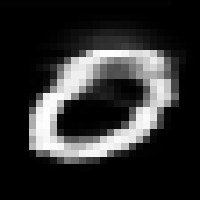

In [70]:
transforms.ToPILImage()(model(x[202].view(-1, 28*28))[0].view(28, 28)).resize((200, 200),0)

In [134]:
#@markdown Sample from the model.

import random

def sample(sample_size: int = 1):
    input_size = 28 * 28
    model_input = torch.zeros(sample_size, input_size).to(float)

    for i in range(input_size):
        probs = model(model_input)[0][:, : i + 1]
        distribution = torch.distributions.Bernoulli(probs=probs)
        model_input[:, i] = distribution.sample()[:, i]


    return model_input

In [176]:
from torchvision.utils import save_image

s = sample(64).view(-1, 1, 28,28)
save_image(s, './samples.png')